# ECE-5424 / CS-5824 Advanced Machine Learning
# Assignment 3: Fully-Connected Neural Nets


## Submission guideline

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your Virginia Tech PID below.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of ll cells).
4. Select Cell -> Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are there, displayed correctly. 
7. Zip the all the files along with this notebook (Please don't include the data)
8. Submit your zipped file and the PDF **INDEPENDENTLY**.

### Please Write Your VT PID Here: 906208012


## Introduction

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.


This assignment is borrowed and modified from [Stanford CS231](http://cs231n.stanford.edu/).






In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

### Download data:
Once you have the starter code (regardless of which method you choose above), you will need to download the CIFAR-10 dataset. Run the following from the HW3 directory:

```cd cs231n/datasets
./get_datasets.sh
```

In [3]:
# Load the (preprocessed) CIFAR10 data.
# cd cs231n/datasets
# ./get_datasets.sh

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: foward [10pts]
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [4]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

print('input_size',input_size)
print('weight_size',weight_size)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

print('shape of x',x.shape)


out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

input_size 240
weight_size 360
shape of x (2, 4, 5, 6)
Testing affine_forward function:
difference:  9.7698500479884e-10


# Affine layer: backward [10pts]
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [5]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5) # derivative of loss wrt output

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

print('dx_num.shape',dx_num.shape)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx_num.shape (10, 2, 3)
Testing affine_backward function:
dx error:  1.0908210113205496e-10
dw error:  2.273805557790167e-10
db error:  7.736978834487815e-12


# ReLU activation: forward [5pts]
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [6]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward [5pts]
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [7]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
The problem being spoken of here is the vanishing gradient problem. Sigmoid and ReLU activation functions have this problem. In one dimensional case, if the values were negative ReLU would result with vanishing gradients. Values resulting in very small sigmoid values lead to vanishing gradient problems in the case of Sigmoid function.


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [8]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.750573928879482e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax [10pts]

Now let's go back to `cs231n/layers.py` and implement the Softmax loss function in the `softmax_loss` function. See the noted in http://cs231n.github.io/neural-networks-case-study/#grad for a better understanding. 

Test your implementation using numeric gradient checking:

In [9]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)


dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)



# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.483503037636722e-09


# Two-layer network [20pts]
Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [10]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.30e-10
b1 relative error: 8.37e-09
b2 relative error: 1.94e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


# Solver [10pts]
Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [11]:
model = TwoLayerNet()
solver = None

num_epochs = 20
batch_size = 500

regs = [1e-4]
learning_rates = [1e-3]
hyper_params = zip(learning_rates, regs)

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
model=TwoLayerNet(reg=1e-4)
solver=Solver(model,data,update_rule='sgd',optim_config={'learning_rate':1e-3,}, lr_decay=0.95,num_epochs=20,batch_size=500,print_every=100)
solver.train()


##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 1960) loss: 2.301428
(Epoch 0 / 20) train acc: 0.172000; val_acc: 0.166000
(Epoch 1 / 20) train acc: 0.349000; val_acc: 0.372000
(Iteration 101 / 1960) loss: 1.777924
(Epoch 2 / 20) train acc: 0.398000; val_acc: 0.429000
(Iteration 201 / 1960) loss: 1.612447
(Epoch 3 / 20) train acc: 0.427000; val_acc: 0.454000
(Iteration 301 / 1960) loss: 1.571498
(Epoch 4 / 20) train acc: 0.479000; val_acc: 0.461000
(Iteration 401 / 1960) loss: 1.548780
(Epoch 5 / 20) train acc: 0.479000; val_acc: 0.460000
(Iteration 501 / 1960) loss: 1.419021
(Epoch 6 / 20) train acc: 0.497000; val_acc: 0.476000
(Iteration 601 / 1960) loss: 1.458376
(Epoch 7 / 20) train acc: 0.506000; val_acc: 0.490000
(Iteration 701 / 1960) loss: 1.407352
(Epoch 8 / 20) train acc: 0.503000; val_acc: 0.486000
(Iteration 801 / 1960) loss: 1.317950
(Epoch 9 / 20) train acc: 0.542000; val_acc: 0.496000
(Iteration 901 / 1960) loss: 1.404002
(Epoch 10 / 20) train acc: 0.524000; val_acc: 0.489000
(Iteration 1001 / 1960) los

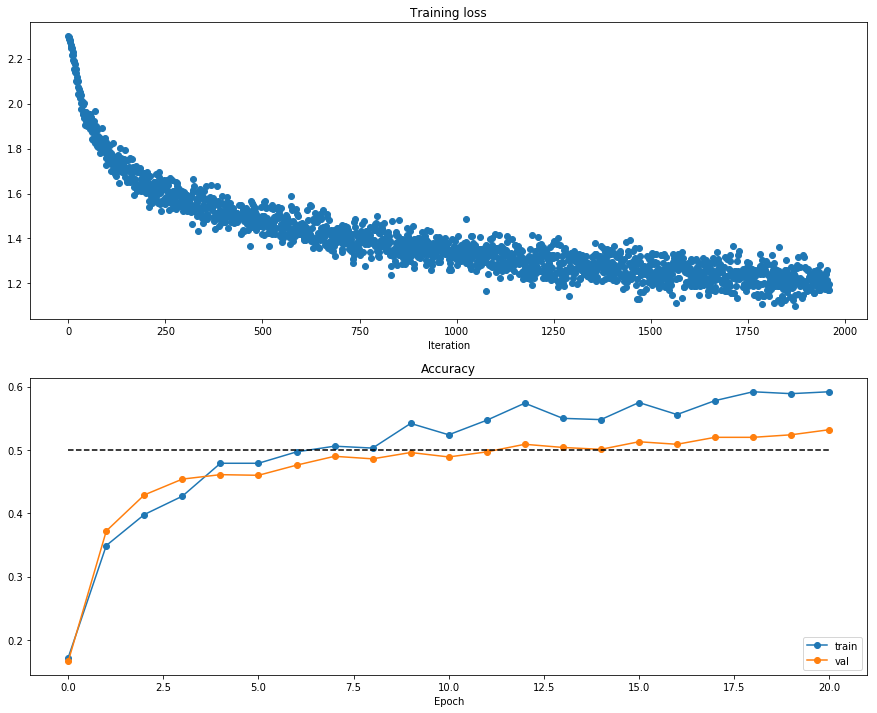

In [12]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network [20pts]
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [13]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 7.70e-08
W2 relative error: 1.71e-05
W3 relative error: 2.95e-07
b1 relative error: 4.66e-09
b2 relative error: 2.09e-09
b3 relative error: 6.60e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 7.36e-09
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.17e-08
b2 relative error: 1.72e-09
b3 relative error: 2.87e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the learning rate and initialization scale to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 15.422921
(Epoch 0 / 20) train acc: 0.080000; val_acc: 0.105000
(Epoch 1 / 20) train acc: 0.080000; val_acc: 0.107000
(Epoch 2 / 20) train acc: 0.280000; val_acc: 0.116000
(Epoch 3 / 20) train acc: 0.380000; val_acc: 0.150000
(Epoch 4 / 20) train acc: 0.500000; val_acc: 0.130000
(Epoch 5 / 20) train acc: 0.620000; val_acc: 0.149000
(Iteration 11 / 40) loss: 1.123091
(Epoch 6 / 20) train acc: 0.700000; val_acc: 0.153000
(Epoch 7 / 20) train acc: 0.760000; val_acc: 0.151000
(Epoch 8 / 20) train acc: 0.780000; val_acc: 0.160000
(Epoch 9 / 20) train acc: 0.880000; val_acc: 0.155000
(Epoch 10 / 20) train acc: 0.880000; val_acc: 0.148000
(Iteration 21 / 40) loss: 0.809509
(Epoch 11 / 20) train acc: 0.900000; val_acc: 0.155000
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.145000
(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.147000
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.148000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.149000
(Iteration 31 / 40) loss:

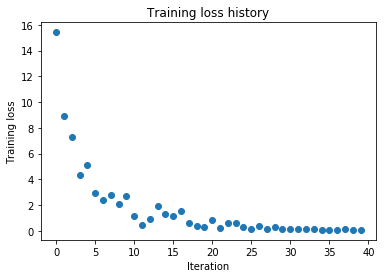

In [14]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 3.5e-2
learning_rate = 0.4e-3
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 5.107555
(Epoch 0 / 20) train acc: 0.260000; val_acc: 0.117000
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.086000
(Epoch 2 / 20) train acc: 0.360000; val_acc: 0.132000
(Epoch 3 / 20) train acc: 0.540000; val_acc: 0.139000
(Epoch 4 / 20) train acc: 0.740000; val_acc: 0.145000
(Epoch 5 / 20) train acc: 0.860000; val_acc: 0.131000
(Iteration 11 / 40) loss: 1.037668
(Epoch 6 / 20) train acc: 0.780000; val_acc: 0.134000
(Epoch 7 / 20) train acc: 0.880000; val_acc: 0.155000
(Epoch 8 / 20) train acc: 0.920000; val_acc: 0.139000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.138000
(Epoch 10 / 20) train acc: 0.960000; val_acc: 0.146000
(Iteration 21 / 40) loss: 0.449057
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.140000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.143000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.152000
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.134000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.135000
(Iteration 31 / 40) loss: 

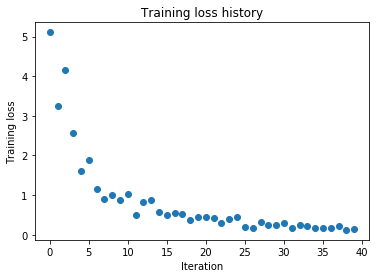

In [15]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 4.5e-3
weight_scale  = 4.9e-2
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

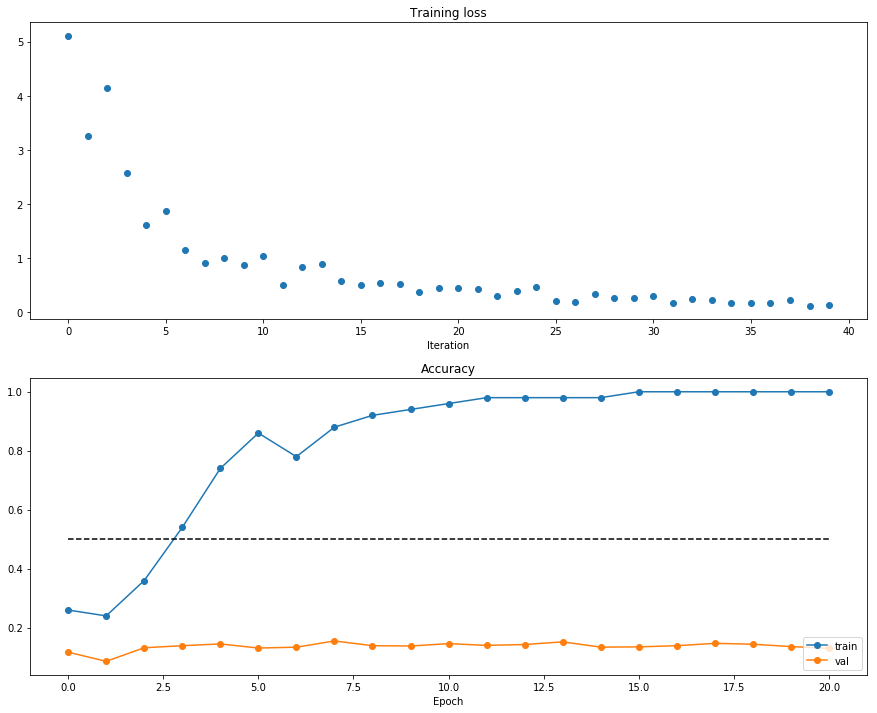

In [16]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

## Inline Question 2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
The network with three layers converges sooner for smaller values of initialization scale. As the number of layers increase, it is required to have larger initialization scale. Initialization scale refers to the spread of weights. As the number of layers increase, it is advisable to have a larger set of weights in order to avoid the vanishing gradient problem. 


# Train a good model![10pts]
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so.

In [17]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################

learning_rate = 1.5e-03
weight_scale = 3.0e-03
model = FullyConnectedNet([100, 100],weight_scale=weight_scale, dtype=np.float64)

solver = Solver(model, data,

print_every=100, num_epochs=20,
update_rule='sgd',
optim_config={
'learning_rate': learning_rate,
}
)
solver.train()
best_model = model
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 9800) loss: 2.302181
(Epoch 0 / 20) train acc: 0.096000; val_acc: 0.087000
(Iteration 101 / 9800) loss: 2.298815
(Iteration 201 / 9800) loss: 2.284066
(Iteration 301 / 9800) loss: 2.152615
(Iteration 401 / 9800) loss: 2.039694
(Epoch 1 / 20) train acc: 0.254000; val_acc: 0.276000
(Iteration 501 / 9800) loss: 2.020663
(Iteration 601 / 9800) loss: 1.945398
(Iteration 701 / 9800) loss: 1.814126
(Iteration 801 / 9800) loss: 1.829223
(Iteration 901 / 9800) loss: 1.788701
(Epoch 2 / 20) train acc: 0.347000; val_acc: 0.371000
(Iteration 1001 / 9800) loss: 1.853874
(Iteration 1101 / 9800) loss: 1.876546
(Iteration 1201 / 9800) loss: 1.722005
(Iteration 1301 / 9800) loss: 1.564326
(Iteration 1401 / 9800) loss: 1.694145
(Epoch 3 / 20) train acc: 0.422000; val_acc: 0.419000
(Iteration 1501 / 9800) loss: 1.704343
(Iteration 1601 / 9800) loss: 1.887307
(Iteration 1701 / 9800) loss: 1.686368
(Iteration 1801 / 9800) loss: 1.634955
(Iteration 1901 / 9800) loss: 1.556920
(Epoch 4 / 20) t

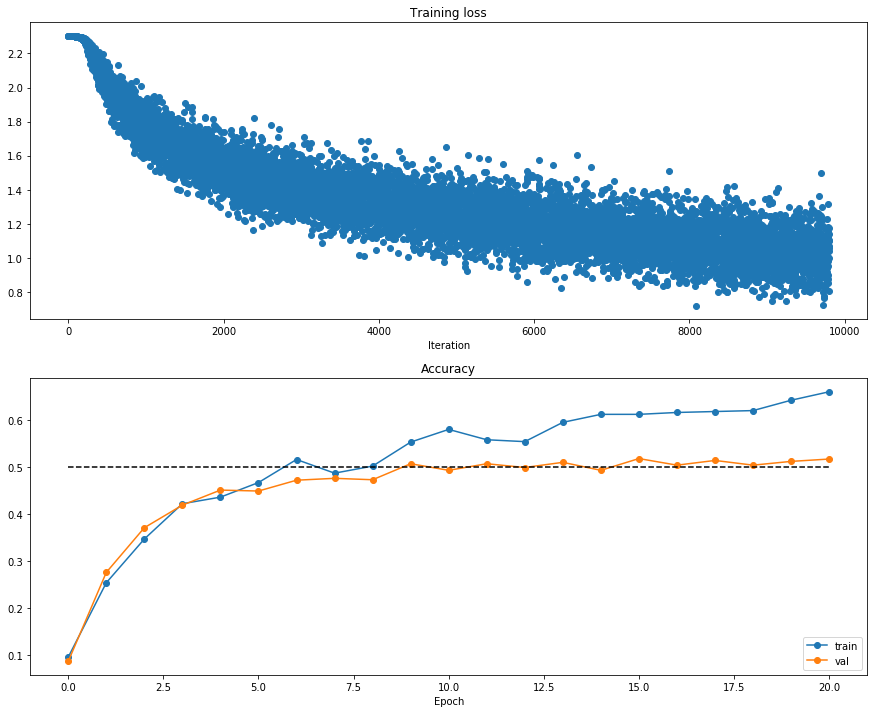

In [18]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Test your model! 
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [19]:
best_model = model

y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.518
Test set accuracy:  0.526
